In [2]:
%load_ext autoreload

In [3]:
%autoreload 2

In [4]:
import numpy as np
from numpy import sqrt
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
def set_fontsize(ax, fs):
    """
    Small function to set font sizes for figures
    """
    ax.tick_params(axis='both', which='major', labelsize=fs)
    ax.tick_params(axis='both', which='minor', labelsize=fs)
    ax.xaxis.label.set_size(fs)
    ax.yaxis.label.set_size(fs)
    ax.title.set_size(fs)

In [5]:
%%time
from quantumoperators import *
from hamiltonianoperators import *

Jmax = 6      # max J value in Hamiltonian
I_Tl = 1/2    # I1 in Ramsey's notation
I_F = 1/2     # I2 in Ramsey's notation

HamiltonianJ6 = Hamiltonian(Jmax, I_Tl, I_F)

Wall time: 56 s


In [28]:
import h5py
hf = h5py.File('HamiltonianConstructionTerms.h5', 'w')
hf.create_dataset('Hff', data = HamiltonianJ6.Hff_m)
hf.create_dataset('HSx', data = HamiltonianJ6.HSx_m)
hf.create_dataset('HSy', data = HamiltonianJ6.HSy_m)
hf.create_dataset('HSz', data = HamiltonianJ6.HSz_m)
hf.create_dataset('HZx', data = HamiltonianJ6.HZx_m)
hf.create_dataset('HZy', data = HamiltonianJ6.HZy_m)
hf.create_dataset('HZz', data = HamiltonianJ6.HZz_m)
hf.close()

In [29]:
Hterms = (HamiltonianJ6.Hff_m, HamiltonianJ6.HSx_m, HamiltonianJ6.HSy_m, HamiltonianJ6.HSz_m, 
          HamiltonianJ6.HZx_m, HamiltonianJ6.HZy_m, HamiltonianJ6.HZz_m)

# Loading Trajectories and Fields

In [6]:
from trajectories import *
positions = load_trajectories('positions_545.mat')
velocities = load_velocities('velocities_545.mat')

t, (xT, yT, zT), (xVelocity, yVelocity, zVelocity) = get_time_position_velocity(positions, velocities)

Need this function here in order to pickle the lambda functions

In [7]:
def makeInterpolate(t,x,y,z):
    intTrajX = interp1d(t, x, kind = 'linear')
    intTrajY = interp1d(t, y, kind = 'quadratic')
    intTrajZ = interp1d(t, z, kind = 'linear')

    rootfun = lambda t: intTrajZ(t) - (0.8052-0.15)
    tstart = brentq(rootfun, 0.001, 0.015)
    rootfun = lambda t: intTrajZ(t) - (0.8052+0.6+0.15)
    tstop = brentq(rootfun, 0.001, 0.015)
    
    intTrajX = interp1d(t-tstart, x, kind = 'linear')
    intTrajY = interp1d(t-tstart, y, kind = 'quadratic')
    intTrajZ = interp1d(t-tstart, z-(0.8052-0.15)-0.45, kind = 'linear')
    
    return intTrajX, intTrajY, intTrajZ, tstop-tstart

In [8]:
interpolateTrajectories = []
for idInt in range(t.shape[1]):
    interpolateTrajectories.append((makeInterpolate(t[:,idInt], xT[:,idInt], yT[:,idInt], zT[:,idInt])))

In [9]:
import pickle
with open('trajectories', 'wb') as wfp:
    pickle.dump(interpolateTrajectories, wfp)

In [10]:
del t, xT, yT, zT, xVelocity, yVelocity, zVelocity

In [11]:
from fields import *
c, intfun = fit_potential_xyz("D:/Adiabatic Transfer/propagation/fields/"+'potentialQuadrupole.fld', 0.022, 0.019, 0, 0)
cP, intfunP = fit_potential_xyz('D:/Adiabatic Transfer/propagation/fields/'+'potentialElectrodes.fld', 0.022, 0.019, .45, 0)
funEx,funEy,funEz,funEmag = combine_quadrupole_plate(c,intfun,cP,intfunP)

C:\Users\Olivier\Documents\CeNTREX Olivier\notebooks\non-adiabatic transitions\propagation\fields.py:46: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  c = np.linalg.lstsq(vander, f)[0]


# Propagation

# Multiprocessing

In [36]:
from tqdm import tqdm_notebook as tqdm

def progress_thread(q, total, workers):
    """
    Creating a progress bar using tqdm usable over multiple processes
    """
    done = 0
    pbar = tqdm(total=total)
    while True:
        val = q.get()
        if val != None:
            pbar.update(1)
        else:
            done += 1
        if done == workers:
            pbar.close()
            break

In [37]:
def prepare_ranges(workers, totRange):
    if workers > 1:
        ranges = [(i*int(totRange/(workers)), ((i+1)*int(totRange/(workers)))) for i in range(workers-1)]
        ranges.append((ranges[-1][-1],totRange))
    else:
        ranges = [(0, totRange)]
    return ranges

In [38]:
def combine_multipool(results):
    idT_list, phi0_list, phi_list, H0_list, H_list = [], [], [], [], []
    for idx in range(len(results)):
        idT_list.extend(results[idx][0])
        phi0_list.extend(results[idx][1])
        phi_list.extend(results[idx][2])
        H0_list.extend(results[idx][3])
        H_list.extend(results[idx][4])
    return idT_list, phi0_list, phi_list, H0_list, H_list

In [48]:
import multiprocessing
import threading
from state_propagation_multiprocessing import propagate_multi

# set # cores to utilize
nrCores = 2
# level to propagate
start_level = 35
# Hamiltonian components
Hterms = [Hff_m, HSx_m, HSy_m, HSz_m, HZx_m, HZy_m, HZz_m]
# total trajectories
nrTrajectories = 500

ranges = prepare_ranges(nrCores,nrTrajectories)

if __name__ == '__main__':
    m = multiprocessing.Manager()
    q = m.Queue()
    progress = threading.Thread(target=progress_thread, args=(q, nrTrajectories, nrCores))
    progress.start()

    args = [(start_level, (0, 20, 0), Hterms, r, (5e-7,1e-6), 'trajectories', 'interpolatePotential', q) \
             for r in ranges]

    pool = multiprocessing.Pool(processes = nrCores)
    result = pool.map(propagate_multi, args)
    pool.close()
    pool.join()

100%|██████████| 500/500 [15:29:06<00:00, 126.25s/it]


In [49]:
idT_list, phi0_list, phi_list, H0_list, H_list = combine_multipool(result)

In [13]:
import h5py
hf = h5py.File('calculatedProbabilities545_200V_20G_5cm.h5', 'w')
hf.create_dataset('idT', data = idT_list)
hf.create_dataset('phi0', data = phi0_list)
hf.create_dataset('phi', data =
                  phi_list)
hf.create_dataset('H0', data = H0_list)
hf.create_dataset('H', data = H_list)
hf.close()

NameError: name 'idT_list' is not defined

In [13]:
import h5py
nrTrajectories = 500
data_dir = "D:/Adiabatic Transfer/propagation/probabilities/"
hf = h5py.File(data_dir + 'calculatedProbabilities545_200V_20G_5cm.h5', 'r')
idT_list = hf['idT']
phi0_list = hf['phi0']
phi_list = hf['phi']
H0_list = hf['H0']
H_list = hf['H']

In [14]:
idL = 10
np.abs(phi_list[idL].conj()@phi0_list[idL])**2

0.9971848500592342

In [15]:
tmp = []
for idL in range(500):
    tmp.append(np.abs(phi_list[idL].conj()@phi0_list[idL])**2)

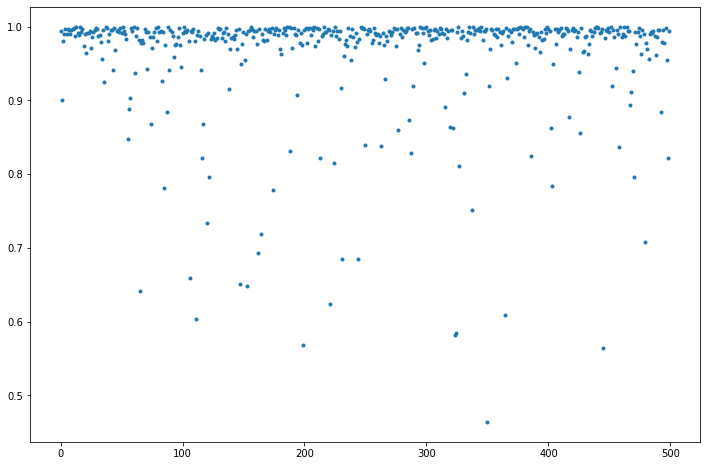

In [16]:
fig, ax = plt.subplots(figsize = (12,8))
ax.plot(tmp, '.')

In [17]:
x0 = []
y0 = []
for idL in range(500):
    traj = interpolateTrajectories[idL]
    x0.append(traj[0](0.000))
    y0.append(traj[1](0.000))
x0 = np.array(x0)
y0 = np.array(y0)

In [18]:
from scipy.interpolate import griddata
xi, yi = np.linspace(x0.min(), x0.max(), 15), np.linspace(y0.min(), y0.max(), 30)
X, Y = np.meshgrid(xi, yi)
Z = griddata((x0,y0), tmp, (X,Y), method = 'linear')

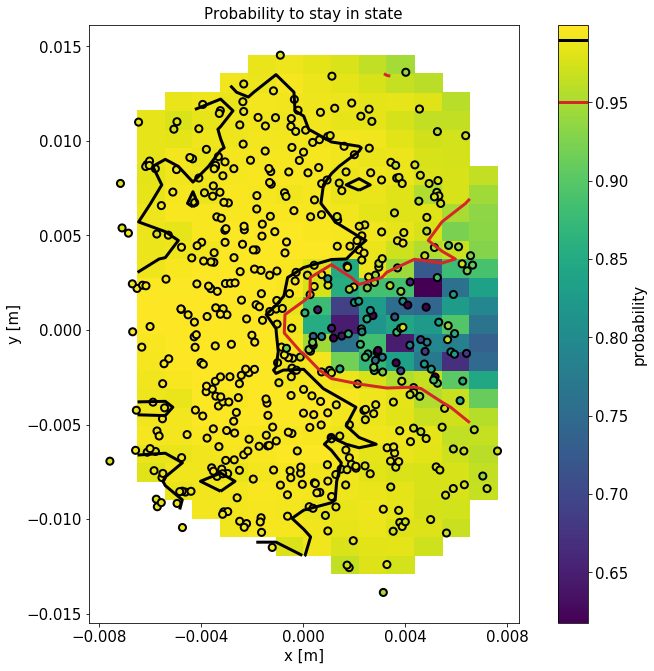

In [19]:
from matplotlib import colors
fig, ax = plt.subplots(figsize = (14,11))
cax = ax.pcolormesh(X,Y,Z)
vmin, vmax = cax.get_clim()
ax.scatter(x0, y0, c = tmp, edgecolors = 'k', s = 50, vmin = vmin, vmax = vmax, lw = 2)
cbar = fig.colorbar(cax)
cbar.set_label('probability', fontsize = 15)
cs = ax.contour(xi, yi, Z, colors = ['C3', 'k'], levels = [0.95, 0.99], linewidths = 3)
cbar.add_lines(cs)
ax.set_xlabel("x [m]", fontsize = 15)
ax.set_ylabel("y [m]", fontsize = 15)
ax.set_title('Probability to stay in state', fontsize = 15);
ax.set_xticks([-0.008, -0.004, 0, 0.004, 0.008])
set_fontsize(ax, 15)
set_fontsize(cbar.ax, 15)
ax.set_aspect(1/1.35)

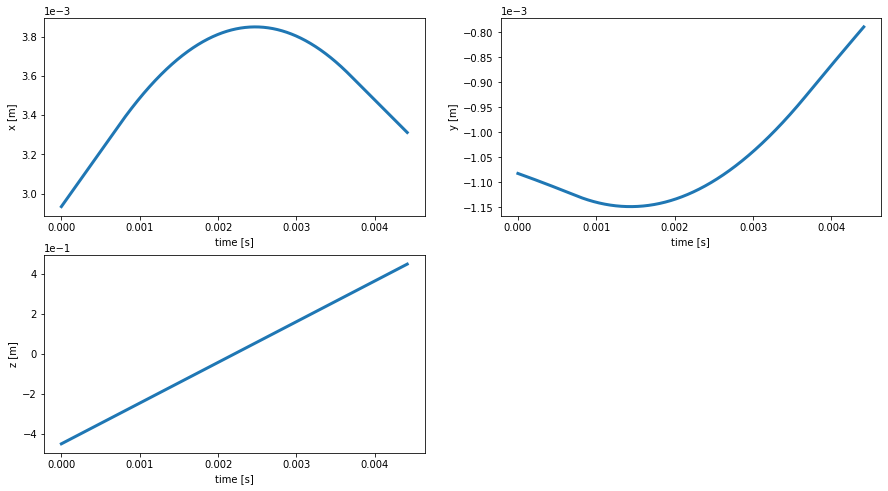

In [20]:
idmin = np.argmin(tmp)

traj = interpolateTrajectories[idmin]
t = np.linspace(0,traj[-1],10000)
fig, axs = plt.subplots(2, 2, figsize = (15,8))
axs[0][0].plot(t, traj[0](t), lw = 3)
axs[0][1].plot(t, traj[1](t), lw = 3)
axs[1][0].plot(t, traj[2](t), lw = 3)

for ax in axs.flat:
    ax.set_xlabel('time [s]')
    ax.ticklabel_format(axis = 'y', style='sci', scilimits = (4,-2))
#     ax.label_outer()

for ax, ylabel in zip(axs.flat, 'x,y,z'.split(',')):
    ax.set_ylabel(f'{ylabel} [m]')

fig.delaxes(axs[1][1])

fig.savefig('bad_trajectory.png', dpi = 300)

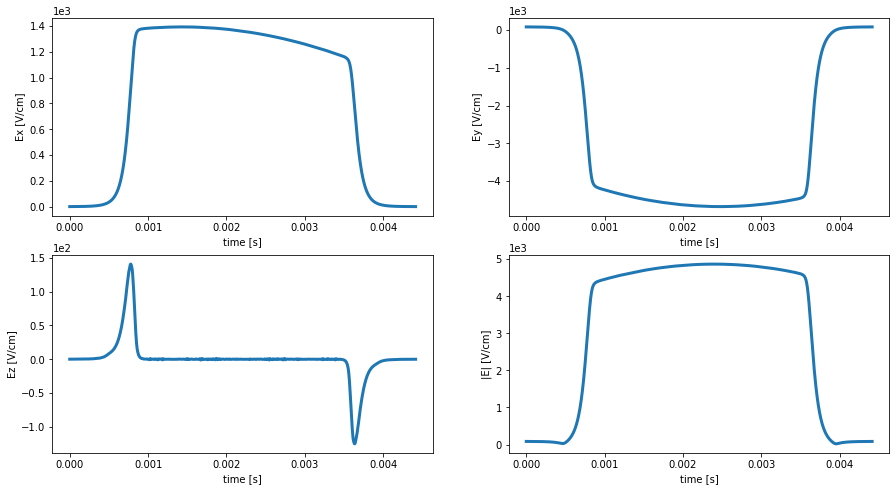

In [21]:
fig, axs = plt.subplots(2, 2, figsize = (15,8))
axs[0][0].plot(t, funEx(traj[0](t), traj[1](t), traj[2](t)), lw = 3)
axs[0][1].plot(t, funEy(traj[0](t), traj[1](t), traj[2](t)), lw = 3)
axs[1][0].plot(t, funEz(traj[0](t), traj[1](t), traj[2](t)), lw = 3)
axs[1][1].plot(t, funEmag(traj[0](t), traj[1](t), traj[2](t)), lw = 3)

for ax in axs.flat:
    ax.set_xlabel('time [s]')
    ax.ticklabel_format(axis = 'y', style='sci', scilimits = (4,-2))
#     ax.label_outer()

for ax, ylabel in zip(axs.flat, 'Ex,Ey,Ez,|E|'.split(',')):
    ax.set_ylabel(f'{ylabel} [V/cm]')
    
fig.savefig('fields_bad_trajectory.png', dpi = 300)

In [22]:
funEVec = lambda x,y,z: np.array([funEx(x,y,z), funEy(x,y,z), funEz(x,y,z)]).T

def Erotation(traj):
    t = np.linspace(0,traj[3],4001)
    xi, yi, zi = traj[0](t), traj[1](t), traj[2](t)

    Evec = funEVec(xi,yi,zi)
    angle = np.arccos(np.einsum('ij,ij->i',Evec[1:,:],Evec[:-1,:])/\
    (np.linalg.norm(Evec[1:,:], axis = 1)*np.linalg.norm(Evec[:-1,:], axis = 1)))
    return t[1:], angle, angle/np.diff(t)

def ErotationInit(traj):
    t = np.linspace(0,traj[3],4001)
    xi, yi, zi = traj[0](t), traj[1](t), traj[2](t)

    Evec = funEVec(xi,yi,zi)
    angle = np.arccos(np.einsum('ij,ij->i',Evec[1:,:],Evec[0:1,:])/\
    (np.linalg.norm(Evec[1:,:], axis = 1)*np.linalg.norm(Evec[0:1,:], axis = 1)))
    return t[1:], angle

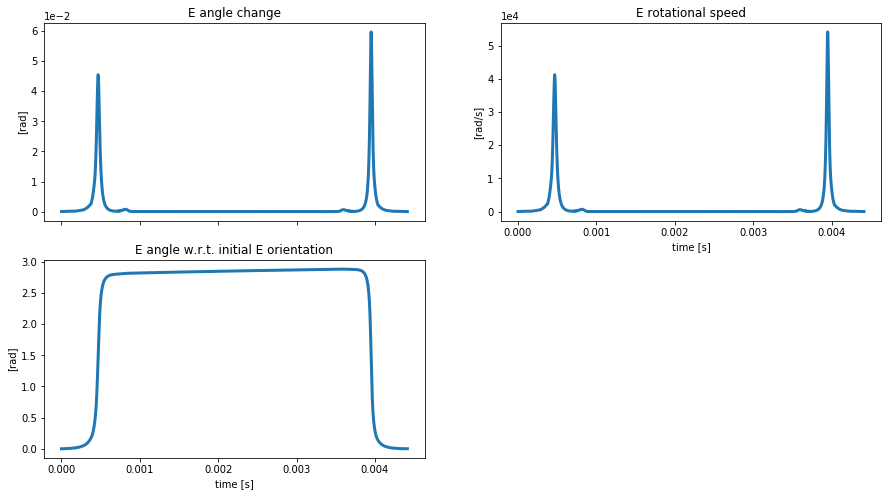

In [23]:
tangle, angle, speed = Erotation(traj)
tangle, angle_init = ErotationInit(traj)

fig, axs = plt.subplots(2, 2, figsize = (15,8))
axs[0][0].plot(tangle, angle, lw = 3)
axs[0][1].plot(tangle, speed, lw = 3)
axs[1][0].plot(tangle, angle_init, lw = 3)

for ax in axs.flat:
    ax.set_xlabel('time [s]')
    ax.ticklabel_format(axis = 'y', style='sci', scilimits = (4,-2))

for ax, ylabel in zip(axs.flat, '[rad],[rad/s],[rad]'.split(',')):
    ax.set_ylabel(f'{ylabel}')
    
for ax, title in zip(axs.flat, 'E angle change,E rotational speed,E angle w.r.t. initial E orientation'.split(',')):
    ax.set_title(f'{title}')

plt.setp(axs[0][0].get_xticklabels(), visible=False)
axs[0][0].set_xlabel('')
    
fig.delaxes(axs[1][1])

fig.savefig('angle_field_bad_trajectory.png', dpi = 300)

In [24]:
ti = tangle[np.argmax(speed)]
funEmag(traj[0](ti), traj[1](ti), traj[2](ti))

18.88246323647158

In [25]:
funEmag(traj[0](t), traj[1](t), traj[2](t)).min()

18.765914796506078

In [26]:
tangle[np.argmax(angle)]

0.0039507900122006945

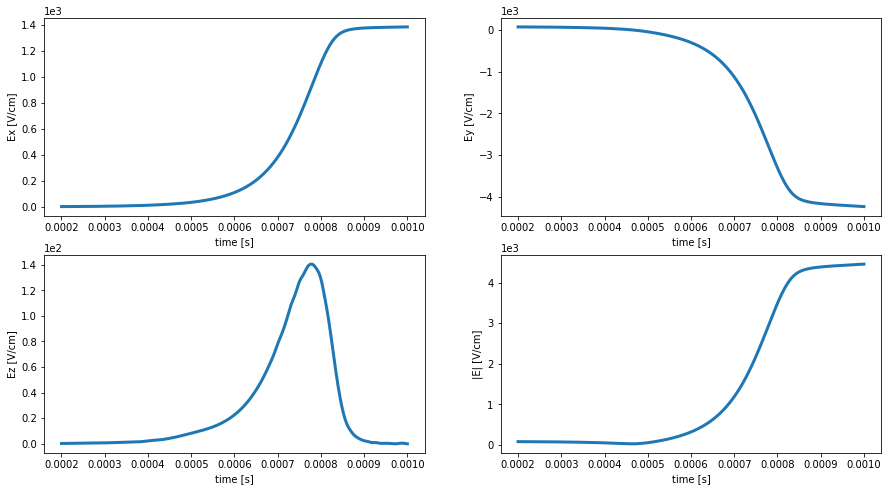

In [34]:
fig, axs = plt.subplots(2, 2, figsize = (15,8))
ti = tangle[np.argmax(speed)]
tr = np.linspace(0.0002, 0.001, 1000)
axs[0][0].plot(tr, funEx(traj[0](tr), traj[1](tr), traj[2](tr)), lw = 3)
axs[0][1].plot(tr, funEy(traj[0](tr), traj[1](tr), traj[2](tr)), lw = 3)
axs[1][0].plot(tr, funEz(traj[0](tr), traj[1](tr), traj[2](tr)), lw = 3)
axs[1][1].plot(tr, funEmag(traj[0](tr), traj[1](tr), traj[2](tr)), lw = 3)

for ax in axs.flat:
    ax.set_xlabel('time [s]')
    ax.ticklabel_format(axis = 'y', style='sci', scilimits = (4,-2))
#     ax.label_outer()

for ax, ylabel in zip(axs.flat, 'Ex,Ey,Ez,|E|'.split(',')):
    ax.set_ylabel(f'{ylabel} [V/cm]')

In [36]:
funEy(traj[0](tr), traj[1](tr), traj[2](tr))[:10]

array([78.88085356, 78.84561718, 78.80989784, 78.77369422, 78.73700502,
       78.69982895, 78.66216469, 78.62401094, 78.58536646, 78.54623111])

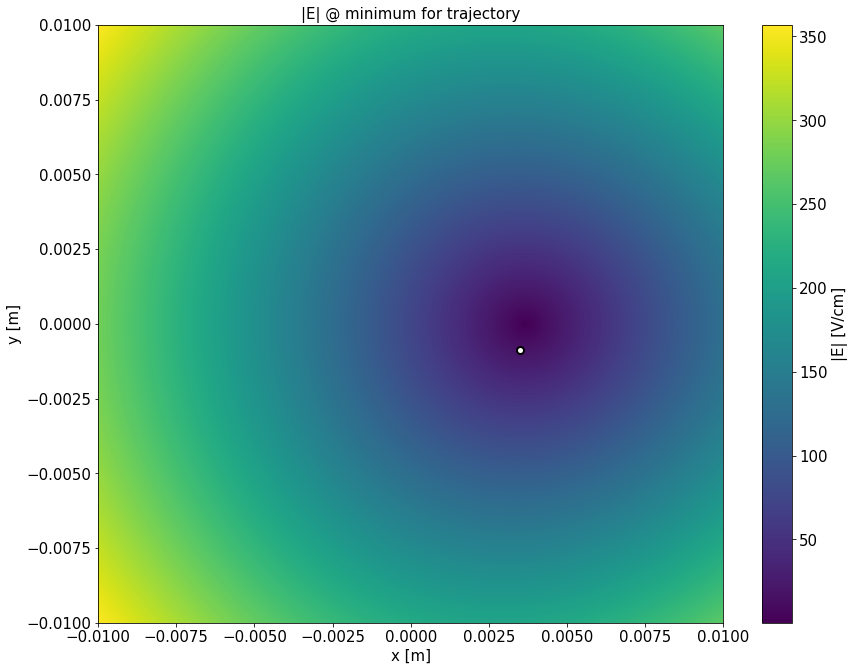

In [171]:
from scipy.interpolate import griddata
xi, yi = np.linspace(-0.01, 0.01, 1000), np.linspace(-0.01, 0.01, 1000)
X,Y = np.meshgrid(xi,yi)
tmin = t[funEmag(traj[0](t), traj[1](t), traj[2](t)).argmin()]
Z = funEmag(X,Y,traj[2](tmin))

# from matplotlib import colors
fig, ax = plt.subplots(figsize = (14,11))
cax = ax.pcolormesh(X,Y,Z, vmax = Z.max())
vmin, vmax = cax.get_clim()
ax.scatter(traj[0](tmin), traj[1](tmin), c = 'w', edgecolors = 'k', s = 50, vmin = vmin, vmax = vmax, lw = 2)
cbar = fig.colorbar(cax)
cbar.set_label('|E| [V/cm]', fontsize = 15)
# cbar.add_lines(cs)
ax.set_xlabel("x [m]", fontsize = 15)
ax.set_ylabel("y [m]", fontsize = 15)
ax.set_title('|E| @ minimum for trajectory', fontsize = 15);
set_fontsize(ax, 15)
set_fontsize(cbar.ax, 15)

fig.savefig('field_map_bad_trajectory.png', dpi = 300)

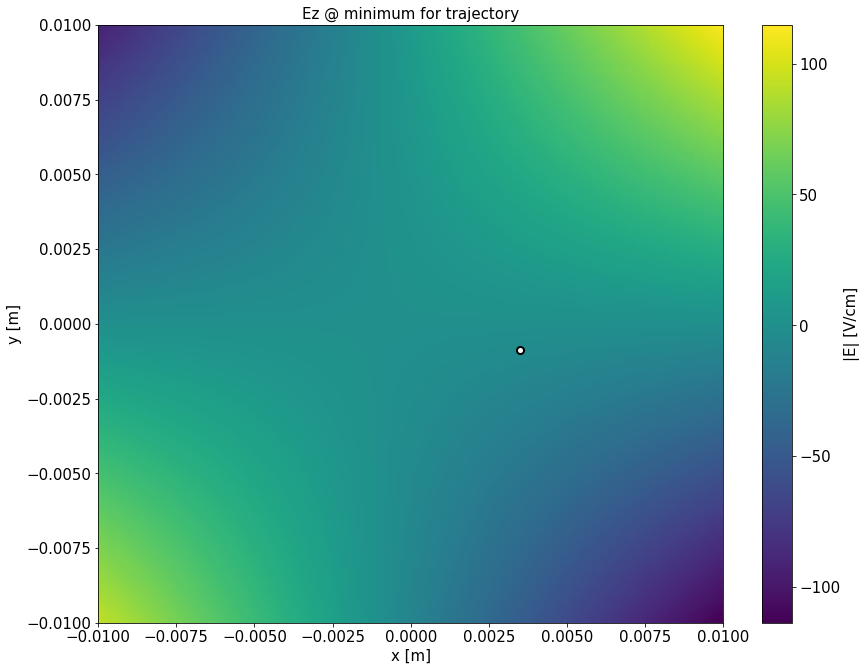

In [186]:
from scipy.interpolate import griddata
xi, yi = np.linspace(-0.01, 0.01, 200), np.linspace(-0.01, 0.01, 200)
X,Y = np.meshgrid(xi,yi)
tmin = t[funEmag(traj[0](t), traj[1](t), traj[2](t)).argmin()]
Z = funEz(X,Y,traj[2](tmin))

# from matplotlib import colors
fig, ax = plt.subplots(figsize = (14,11))
cax = ax.pcolormesh(X,Y,Z, vmax = Z.max())
vmin, vmax = cax.get_clim()
ax.scatter(traj[0](tmin), traj[1](tmin), c = 'w', edgecolors = 'k', s = 50, vmin = vmin, vmax = vmax, lw = 2)
cbar = fig.colorbar(cax)
cbar.set_label('|E| [V/cm]', fontsize = 15)
# cbar.add_lines(cs)
ax.set_xlabel("x [m]", fontsize = 15)
ax.set_ylabel("y [m]", fontsize = 15)
ax.set_title('Ez @ minimum for trajectory', fontsize = 15);
set_fontsize(ax, 15)
set_fontsize(cbar.ax, 15)

# fig.savefig('field_map_bad_trajectory.png', dpi = 300)

### 30 Gauss

In [41]:
import multiprocessing
import threading
from state_propagation_multiprocessing import propagate_multi

# set # cores to utilize
nrCores = 2
# level to propagate
start_level = 35
# total trajectories
nrTrajectories = 500

ranges = prepare_ranges(nrCores,nrTrajectories)

if __name__ == '__main__':
    m = multiprocessing.Manager()
    q = m.Queue()
    progress = threading.Thread(target=progress_thread, args=(q, nrTrajectories, nrCores))
    progress.start()

    args = [(start_level, (0, 30, 0), Hterms, r, (5e-7,1e-6), 'trajectories', 'interpolatePotential', q) \
             for r in ranges]

    pool = multiprocessing.Pool(processes = nrCores)
    result = pool.map(propagate_multi, args)
    pool.close()
    pool.join()

In [42]:
idT_list, phi0_list, phi_list, H0_list, H_list = combine_multipool(result)

In [43]:
import h5py
hf = h5py.File('calculatedProbabilities545_200V_30G_5cm.h5', 'w')
hf.create_dataset('idT', data = idT_list)
hf.create_dataset('phi0', data = phi0_list)
hf.create_dataset('phi', data = phi_list)
hf.create_dataset('H0', data = H0_list)
hf.create_dataset('H', data = H_list)
hf.close()

In [34]:
hf = h5py.File('calculatedProbabilities545_200V_30G_5cm.h5', 'r')
idT_list = hf['idT']
phi0_list = hf['phi0']
phi_list = hf['phi']
H0_list = hf['H0']
H_list = hf['H']

In [35]:
probabilities = []
for idT in range(nrTrajectories):
    probabilities.append(np.abs(phi_list[idT].conj()@phi0_list[idT])**2)

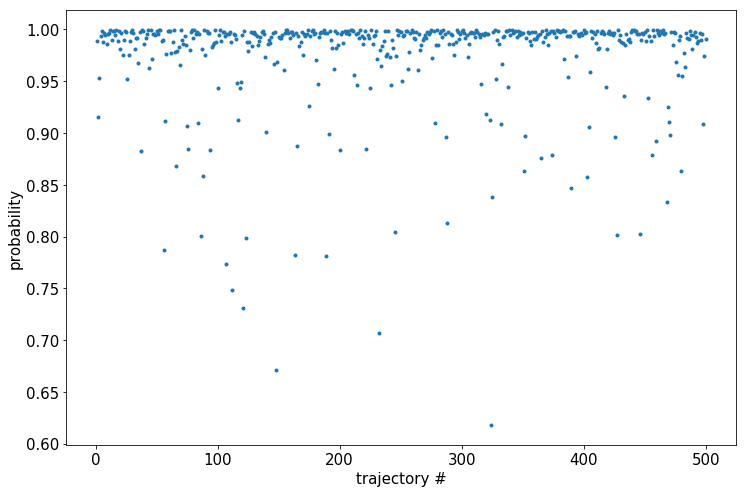

In [36]:
fig, ax = plt.subplots(figsize = (12,8))
ax.plot(np.arange(1,nrTrajectories+1),probabilities, '.')
ax.set_xlabel('trajectory #')
ax.set_ylabel('probability')
set_fontsize(ax, 15)

In [37]:
x0 = []
y0 = []
for idL in range(500):
    traj = interpolateTrajectories[idL]
    x0.append(traj[0](0.000))
    y0.append(traj[1](0.000))
x0 = np.array(x0)
y0 = np.array(y0)

In [38]:
from scipy.interpolate import griddata
xi, yi = np.linspace(x0.min(), x0.max(), 15), np.linspace(y0.min(), y0.max(), 30)
X, Y = np.meshgrid(xi, yi)
Z = griddata((x0,y0), probabilities, (X,Y), method = 'linear')

0.975672330260419


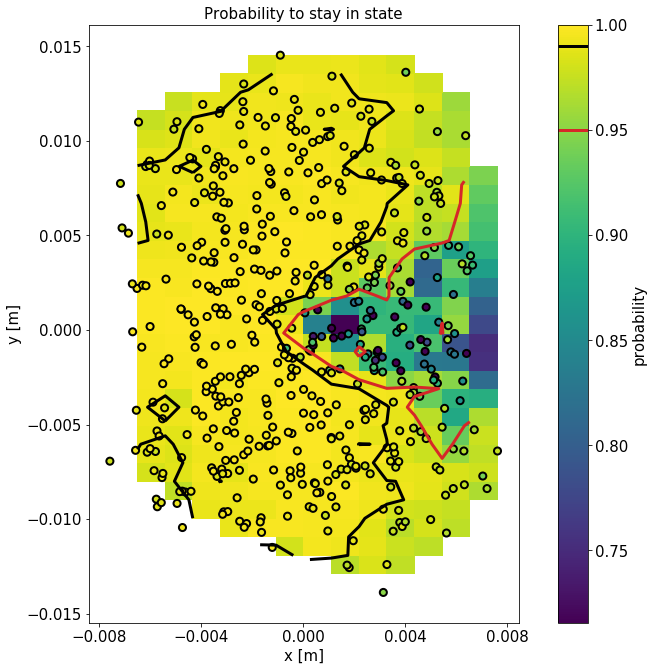

In [39]:
from matplotlib import colors
fig, ax = plt.subplots(figsize = (14,11))
cax = ax.pcolormesh(X,Y,Z, vmax = 1)
vmin, vmax = cax.get_clim()
ax.scatter(x0, y0, c = tmp, edgecolors = 'k', s = 50, vmin = vmin, vmax = vmax, lw = 2)
cbar = fig.colorbar(cax)
cbar.set_label('probability', fontsize = 15)
cs = ax.contour(xi, yi, Z, colors = ['C3', 'k'], levels = [0.95, 0.99], linewidths = 3)
cbar.add_lines(cs)
ax.set_xlabel("x [m]", fontsize = 15)
ax.set_ylabel("y [m]", fontsize = 15)
ax.set_title('Probability to stay in state', fontsize = 15);
ax.set_xticks([-0.008, -0.004, 0, 0.004, 0.008])
set_fontsize(ax, 15)
set_fontsize(cbar.ax, 15)
ax.set_aspect(1/1.35)
print(np.mean(probabilities))

## More trajectories from Oskari

In [247]:
from trajectories import *

positions = load_trajectories('positions_39254.mat')
velocities = load_velocities('velocities_39254.mat')

t, (xT, yT, zT), (xVelocity, yVelocity, zVelocity) = get_time_position_velocity(positions, velocities)

In [248]:
def makeInterpolate(t,x,y,z):
    intTrajX = interp1d(t, x, kind = 'linear')
    intTrajY = interp1d(t, y, kind = 'quadratic')
    intTrajZ = interp1d(t, z, kind = 'linear')

    rootfun = lambda t: intTrajZ(t) - (0.8052-0.15)
    tstart = brentq(rootfun, 0.001, 0.015)
    rootfun = lambda t: intTrajZ(t) - (0.8052+0.6+0.15)
    tstop = brentq(rootfun, 0.001, 0.015)
    
    intTrajX = interp1d(t-tstart, x, kind = 'linear')
    intTrajY = interp1d(t-tstart, y, kind = 'quadratic')
    intTrajZ = interp1d(t-tstart, z-(0.8052-0.15)-0.45, kind = 'linear')
    
    return intTrajX, intTrajY, intTrajZ, tstop-tstart

In [249]:
interpolateTrajectories = []
for idInt in range(t.shape[1]):
    interpolateTrajectories.append((makeInterpolate(t[:,idInt], xT[:,idInt], yT[:,idInt], zT[:,idInt])))

In [250]:
import pickle
with open('trajectoriesNew', 'wb') as wfp:
    pickle.dump(interpolateTrajectories, wfp)
    
del t, xT, yT, zT, xVelocity, yVelocity, zVelocity

### Propagate Along Trajectories

In [307]:
import multiprocessing
import threading
from state_propagation_multiprocessing import propagate_multi

# set # cores to utilize
nrCores = 2
# level to propagate
start_level = 35
# Hamiltonian components
Hterms = [Hff_m, HSx_m, HSy_m, HSz_m, HZx_m, HZy_m, HZz_m]
# total trajectories
nrTrajectories = 500

ranges = prepare_ranges(nrCores,nrTrajectories)

if __name__ == '__main__':
    m = multiprocessing.Manager()
    q = m.Queue()
    progress = threading.Thread(target=progress_thread, args=(q, nrTrajectories, nrCores))
    progress.start()

    args = [(start_level, (0, 20, 0), Hterms, r, (5e-7,1e-6), 'trajectoriesNew', 'interpolatePotential', q) \
             for r in ranges]

    pool = multiprocessing.Pool(processes = nrCores)
    result = pool.map(propagate_multi, args)
    pool.close()
    pool.join()

100%|██████████| 500/500 [13:43:05<00:00, 100.18s/it]


In [308]:
idT_list2, phi0_list2, phi_list2, H0_list2, H_list2 = combine_multipool(result)

In [309]:
import h5py
hf = h5py.File('calculatedProbabilities39254_200V_20G_5cm.h5', 'w')
hf.create_dataset('idT', data = idT_list2)
hf.create_dataset('phi0', data = phi0_list2)
hf.create_dataset('phi', data = phi_list2)
hf.create_dataset('H0', data = H0_list2)
hf.create_dataset('H', data = H_list2)
hf.close()

In [310]:
tmp_2 = []
for idL in range(nrTrajectories):
    tmp_2.append(np.abs(phi_list2[idL].conj()@phi0_list2[idL])**2)

In [311]:
x0_2 = []
y0_2 = []
for idL in range(nrTrajectories):
    traj = interpolateTrajectories[idL]
    x0_2.append(traj[0](0.000))
    y0_2.append(traj[1](0.000))
x0_2 = np.array(x0_2)
y0_2 = np.array(y0_2)

In [312]:
from scipy.interpolate import griddata
xi_2, yi_2 = np.linspace(x0_2.min(), x0_2.max(), 15), np.linspace(y0_2.min(), y0_2.max(), 30)
X_2, Y_2 = np.meshgrid(xi_2, yi_2)
Z_2 = griddata((x0_2,y0_2), tmp_2, (X_2,Y_2), method = 'linear')

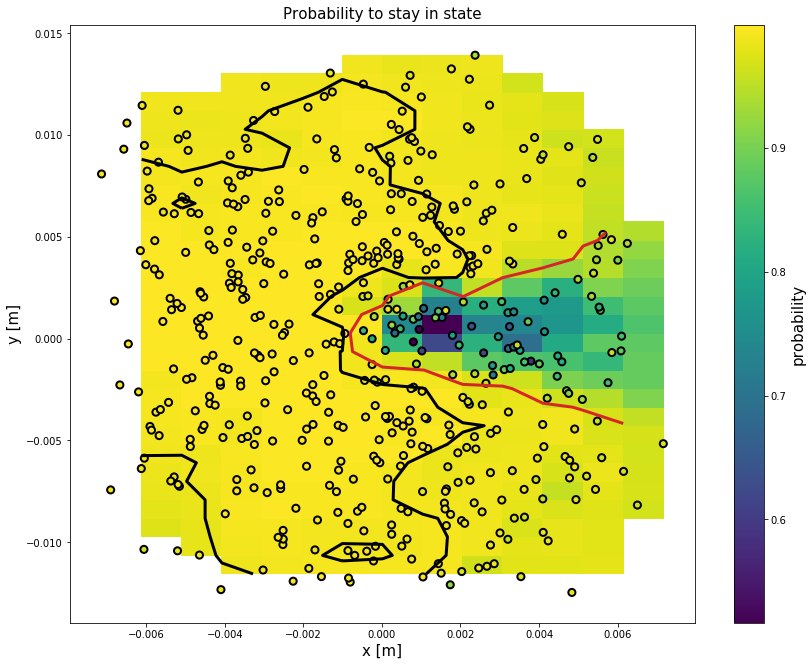

In [313]:
from matplotlib import colors
import matplotlib

fig, ax = plt.subplots(figsize = (14,11))
cax = ax.pcolormesh(X_2,Y_2,Z_2)
cbar = fig.colorbar(cax)
vmin, vmax = cbar.get_clim()
ax.scatter(x0_2, y0_2, c = tmp_2, edgecolors = 'k', s = 50, vmin = vmin, vmax = vmax, lw = 2)
cbar.set_label('probability', fontsize = 15)
ax.contour(xi_2, yi_2, Z_2, colors = ['C3', 'k'], levels = [0.95, 0.99], linewidths = 3)
ax.set_xlabel("x [m]", fontsize = 15)
ax.set_ylabel("y [m]", fontsize = 15)
ax.set_title('Probability to stay in state', fontsize = 15);
# ax.set_aspect(yi.ptp()/xi.ptp())

In [357]:
x0_tot  = np.append(x0, x0_2)
y0_tot  = np.append(y0, y0_2)
tmp_tot = tmp+tmp_2

In [364]:
from scipy.interpolate import griddata
xi_tot, yi_tot = np.linspace(x0_tot.min(), x0_tot.max(), 15), np.linspace(y0_tot.min(), y0_tot.max(), 30)
X_tot, Y_tot = np.meshgrid(xi_tot, yi_tot)
Z_tot = griddata((x0_tot,y0_tot), tmp_tot, (X_tot,Y_tot), method = 'linear')

In [369]:
def set_fontsize(ax, fs):
    """
    Small function to set font sizes for figures
    """
    ax.tick_params(axis='both', which='major', labelsize=fs)
    ax.tick_params(axis='both', which='minor', labelsize=fs)
    ax.xaxis.label.set_size(fs)
    ax.yaxis.label.set_size(fs)
    ax.title.set_size(fs)

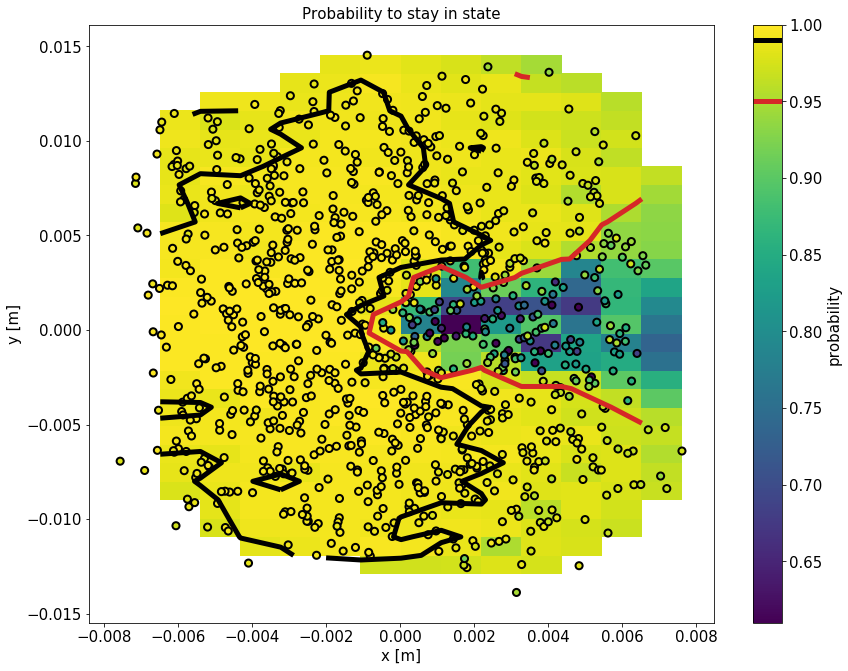

In [404]:
from matplotlib import colors
import matplotlib

fig, ax = plt.subplots(figsize = (14,11))
cax = ax.pcolormesh(X_tot,Y_tot,Z_tot,  vmax = 1)
cax = fig.colorbar(cax)
vmin, vmax = cbar.get_clim()
ax.scatter(x0_tot, y0_tot, c = tmp_tot, edgecolors = 'k', s = 50, vmin = vmin, vmax = vmax, 
           lw = 2)
cbar.set_label('probability', fontsize = 15)
cs = ax.contour(xi_tot, yi_tot, Z_tot, colors = ['C3', 'k'], levels = [0.95, 0.99], 
                linewidths = 5)
cbar.add_lines(cs)
ax.set_xlabel("x [m]", fontsize = 15)
ax.set_ylabel("y [m]", fontsize = 15)
ax.set_title('Probability to stay in state', fontsize = 15);
set_fontsize(ax, 15)
set_fontsize(cbar.ax, 15)
fig.savefig('trajectories_simulated.png', dpi = 150)
# ax.set_aspect(y0_tot.ptp()/x0_tot.ptp())

## 30 Gauss Magnetic Field

In [43]:
def hdf_assign(hf, dataset, idx, data):
    hf[dataset][idx] = data

In [ ]:
from propagation import *
from tqdm import tqdm_notebook as tqdm
import h5py

fname = 'calculatedProbabilities39254_200V_30G_5cm.h5'
nrTrajectories = 1000
B0 = 30

with h5py.File(fname, 'a') as hf:
    hf.create_dataset('idT', shape = (nrTrajectories,), maxshape = (None,))
    hf.create_dataset('phi0', shape = (nrTrajectories,196), maxshape = (None, 196), dtype = 'complex')
    hf.create_dataset('phi', shape = (nrTrajectories,196), maxshape = (None, 196), dtype = 'complex')
    hf.create_dataset('H0', shape = (nrTrajectories,196, 196), maxshape = (None, 196, 196), dtype = 'complex')
    hf.create_dataset('H', shape = (nrTrajectories,196, 196), maxshape = (None, 196, 196), dtype = 'complex')
    hf.close()

funB =  lambda x,y,z: (0, B0, 0)
funE = lambda x,y,z: (funEx(x,y,z), funEy(x,y,z), funEz(x,y,z))

for idT in tqdm(range(nrTrajectories)):
    t, H, phi = propagate_adaptive_save(HamiltonianJ6.create_hamiltonian, interpolateTrajectories[idT], funE, funB, 35, 
                                        dtAdaptive = (5e-7, 1e-6), nstep = 10)
    with h5py.File(fname, 'a') as hf:
        hdf_assign(hf, 'idT', idT, idT)
        hdf_assign(hf, 'phi0', idT, phi[0])
        hdf_assign(hf, 'phi', idT, phi[-1])
        hdf_assign(hf, 'H0', idT, H[0])
        hdf_assign(hf, 'H', idT, H[-1])
        hf.close()

In [ ]:
import multiprocessing
import threading
from state_propagation_multiprocessing import propagate_multi

# set # cores to utilize
nrCores = 1
# level to propagate
start_level = 35
# Hamiltonian components
# total trajectories
nrTrajectories = 1000

ranges = prepare_ranges(nrCores,nrTrajectories)

if __name__ == '__main__':
    m = multiprocessing.Manager()
    q = m.Queue()
    progress = threading.Thread(target=progress_thread, args=(q, nrTrajectories, nrCores))
    progress.start()

    args = [(start_level, (0, 30, 0), Hterms, r, (5e-7,1e-6), 'trajectoriesNew', 'interpolatePotential', q) \
             for r in ranges]

    pool = multiprocessing.Pool(processes = nrCores)
    result = pool.map(propagate_multi, args)
    pool.close()
    pool.join()

In [ ]:
idT_list, phi0_list, phi_list, H0_list, H_list = combine_multipool(result)

In [ ]:
import h5py
hf = h5py.File('calculatedProbabilities39254_200V_30G_5cm.h5', 'w')
hf.create_dataset('idT', data = idT_list)
hf.create_dataset('phi0', data = phi0_list)
hf.create_dataset('phi', data = phi_list)
hf.create_dataset('H0', data = H0_list)
hf.create_dataset('H', data = H_list)
hf.close()

In [251]:
hf = h5py.File('calculatedProbabilities39254_200V_30G_5cm.h5', 'r')
idT_list = hf['idT'].value
phi0_list = hf['phi0'].value
phi_list = hf['phi'].value
H0_list = hf['H0'].value
H_list = hf['H'].value
hf.close()

In [252]:
probabilities = []
for idT in range(nrTrajectories):
    probabilities.append(np.abs(phi_list[idT].conj()@phi0_list[idT])**2)

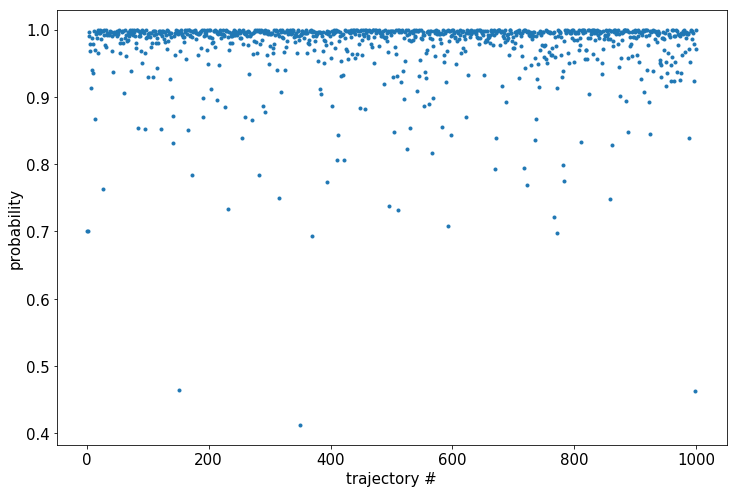

In [253]:
fig, ax = plt.subplots(figsize = (12,8))
ax.plot(np.arange(1,nrTrajectories+1),probabilities, '.')
ax.set_xlabel('trajectory #')
ax.set_ylabel('probability')
set_fontsize(ax, 15)

In [254]:
x0 = []
y0 = []
for idL in range(nrTrajectories):
    traj = interpolateTrajectories[idL]
    ti = np.linspace(0, traj[3], 501)
    xtmp = traj[0](ti)
    ytmp = traj[1](ti)
    ztmp = traj[2](ti)
    idx = find_nearest(ztmp, -0.335768)
    x0.append(xtmp[idx])
    y0.append(ytmp[idx])
#     x0.append(traj[0](0.000))
#     y0.append(traj[1](0.000))
x0 = np.array(x0)
y0 = np.array(y0)
del ti, xtmp, ytmp, ztmp, idx

In [255]:
from scipy.interpolate import griddata
xi, yi = np.linspace(x0.min(), x0.max(), 15), np.linspace(y0.min(), y0.max(), 30)
X, Y = np.meshgrid(xi, yi)
Z = griddata((x0,y0), probabilities, (X,Y), method = 'linear')

0.9739515649657794


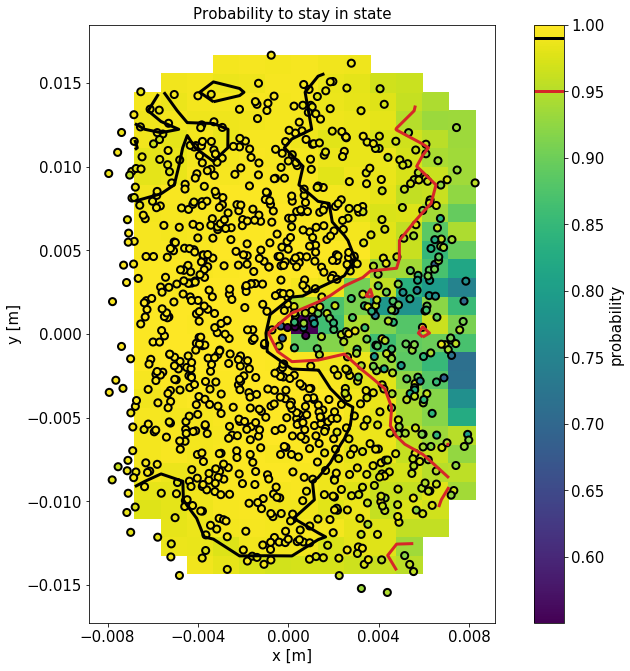

In [256]:
from matplotlib import colors
fig, ax = plt.subplots(figsize = (14,11))
cax = ax.pcolormesh(X,Y,Z, vmax = 1)
vmin, vmax = cax.get_clim()
ax.scatter(x0, y0, c = probabilities, edgecolors = 'k', s = 50, vmin = vmin, vmax = vmax, lw = 2)
cbar = fig.colorbar(cax)
cbar.set_label('probability', fontsize = 15)
cs = ax.contour(xi, yi, Z, colors = ['C3', 'k'], levels = [0.95, 0.99], linewidths = 3)
cbar.add_lines(cs)
ax.set_xlabel("x [m]", fontsize = 15)
ax.set_ylabel("y [m]", fontsize = 15)
ax.set_title('Probability to stay in state', fontsize = 15);
ax.set_xticks([-0.008, -0.004, 0, 0.004, 0.008])
set_fontsize(ax, 15)
set_fontsize(cbar.ax, 15)
ax.set_aspect(1/1.35)
print(np.mean(probabilities))

In [257]:
from trajectories import *
positions = load_trajectories('positions_545.mat')
velocities = load_velocities('velocities_545.mat')

t, (xT, yT, zT), (xVelocity, yVelocity, zVelocity) = get_time_position_velocity(positions, velocities)

In [258]:
interpolateTrajectories = []
for idInt in range(t.shape[1]):
    interpolateTrajectories.append((makeInterpolate(t[:,idInt], xT[:,idInt], yT[:,idInt], zT[:,idInt])))

In [259]:
x0_1 = []
y0_1 = []
for idL in range(500):
    traj = interpolateTrajectories[idL]
    ti = np.linspace(0, traj[3], 501)
    xtmp = traj[0](ti)
    ytmp = traj[1](ti)
    ztmp = traj[2](ti)
    idx = find_nearest(ztmp, -0.335768)
    x0_1.append(xtmp[idx])
    y0_1.append(ytmp[idx])
#     x0_1.append(traj[0](0.000))
#     y0_1.append(traj[1](0.000))
x0_1 = np.array(x0_1)
y0_1 = np.array(y0_1)
del ti, xtmp, ytmp, ztmp, idx

In [260]:
hf = h5py.File('calculatedProbabilities545_200V_30G_5cm.h5', 'r')
idT_list1 = hf['idT'].value
phi0_list1 = hf['phi0'].value
phi_list1 = hf['phi'].value
H0_list1 = hf['H0'].value
H_list1 = hf['H'].value
hf.close()

In [261]:
probabilities1 = []
for idT in range(500):
    probabilities1.append(np.abs(phi_list1[idT].conj()@phi0_list1[idT])**2)

In [262]:
x0_tot  = np.append(x0, x0_1)
y0_tot  = np.append(y0, y0_1)
probabilities_tot = probabilities+probabilities1

In [263]:
from scipy.interpolate import griddata
xi, yi = np.linspace(x0_tot.min(), x0_tot.max(), 15), np.linspace(y0_tot.min(), y0_tot.max(), 30)
X, Y = np.meshgrid(xi, yi)
Z = griddata((x0_tot,y0_tot), probabilities_tot, (X,Y), method = 'linear')

0.9739515649657794


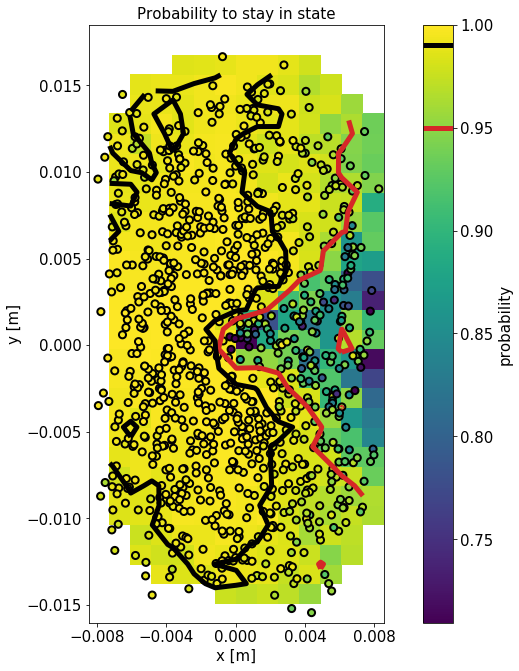

In [279]:
from matplotlib import colors
fig, ax = plt.subplots(figsize = (14,11))
cax = ax.pcolormesh(X,Y,Z, vmax = 1)
vmin, vmax = cax.get_clim()
ax.scatter(x0, y0, c = probabilities, edgecolors = 'k', s = 50, vmin = vmin, vmax = vmax, lw = 2)
cbar = fig.colorbar(cax)
cbar.set_label('probability', fontsize = 15)
cs = ax.contour(xi, yi, Z, colors = ['C3', 'k'], levels = [0.95, 0.99], linewidths = 5)
cbar.add_lines(cs)
ax.set_xlabel("x [m]", fontsize = 15)
ax.set_ylabel("y [m]", fontsize = 15)
ax.set_title('Probability to stay in state', fontsize = 15);
ax.set_xticks([-0.008, -0.004, 0, 0.004, 0.008])
set_fontsize(ax, 15)
set_fontsize(cbar.ax, 15)
ax.set_aspect(1/1)
print(np.mean(probabilities))

In [239]:
funEVec = lambda x,y,z: np.array([funEx(x,y,z), funEy(x,y,z), funEz(x,y,z)]).T

def Erotation(traj):
    t = np.linspace(0,traj[3],4001)
    xi, yi, zi = traj[0](t), traj[1](t), traj[2](t)

    Evec = funEVec(xi,yi,zi)
    angle = np.arccos(np.einsum('ij,ij->i',Evec[1:,:],Evec[:-1,:])/\
    (np.linalg.norm(Evec[1:,:], axis = 1)*np.linalg.norm(Evec[:-1,:], axis = 1)))
    return t[1:], angle, angle/np.diff(t)

In [240]:
from statsmodels.nonparametric.smoothers_lowess import lowess

max_rotation = []
for idT in tqdm(range(len(probabilities))):
    tR, aR, wR = Erotation(interpolateTrajectories[idT])
    
    filtered = lowess(wR, tR, return_sorted = False, frac=0.01, it=0)
    
    max_rotation.append(filtered[:len(tR)//2].max()+filtered[len(tR)//2:].max())

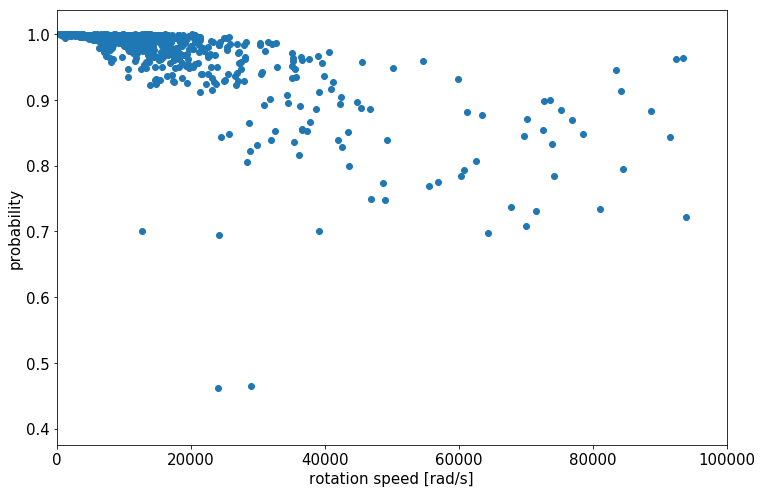

In [241]:
fig, ax = plt.subplots(figsize = (12,8))
ax.scatter(max_rotation, probabilities)
ax.set_xlabel('rotation speed [rad/s]')
ax.set_ylabel('probability')
ax.set_xlim(xmin = 0, xmax = 1e5)
set_fontsize(ax, 15)

In [232]:
def energydiff(H, traj):
    t = np.linspace(0,traj[3],4001)
    xi, yi, zi = traj[0](t), traj[1](t), traj[2](t)
    energies = H.spectrum(*funE(xi,yi,zi), np.zeros(len(xi)), 30*np.ones(len(xi)), np.zeros(len(xi)))
    energies = energies[0]
    return np.abs((energies[:,32:35].T - energies[:,35])).min()

In [234]:
min_distance = []
for idT in tqdm(range(len(probabilities))):
    min_distance.append(energydiff(HamiltonianJ6, interpolateTrajectories[idT]))

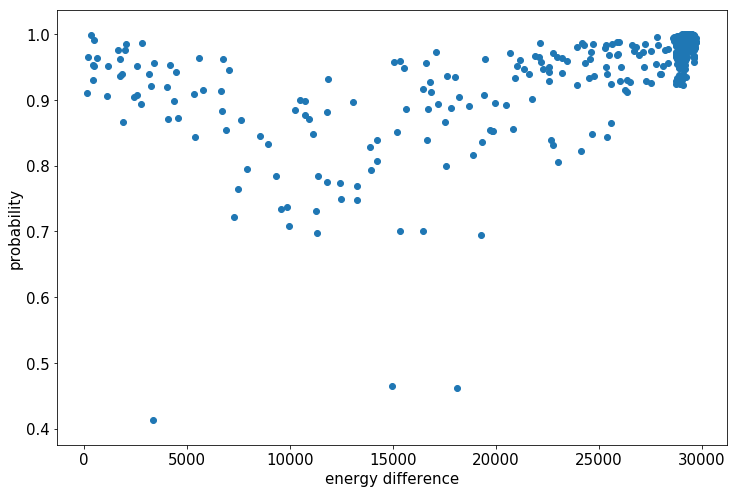

In [236]:
fig, ax = plt.subplots(figsize = (12,8))
ax.scatter(min_distance, probabilities)
ax.set_xlabel('energy difference')
ax.set_ylabel('probability')
set_fontsize(ax, 15)